## 0. Import Library

In [147]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.image import resize

from keras.applications.vgg16 import VGG16

## 1. Load Data

In [39]:
# 경로 설정
data_dir = "../newdataset"

# 이미지 유형 리스트
file_types = ['train', 'val', 'test']
image_types = ['coronal', 'sagittal', 'transverse', 'transverse_stripped', 'transverse_masked']


In [185]:
# 각 파일을 읽어오는 딕셔너리 생성, train, test, validation
coronal = {}
sagittal = {}
transverse = {}
transverse_stripped = {}
transverse_masked = {}
labels = {}

# 파일 읽어 딕셔너리에 저장
for file_type in file_types:
    coronal[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_coronal.npy")
    sagittal[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_sagittal.npy")
    transverse[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_transverse.npy")
    transverse_stripped[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_transverse_stripped.npy")
    transverse_masked[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_transverse_masked.npy")

# 라벨 저장
for file_type in file_types:
    labels[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_labels.npy")
      
# 데이터 출력 
print("coronal train Shape:", coronal["train"].shape)
print("sagittal train Shape:", sagittal["train"].shape)
print("transverse train Shape:", transverse["train"].shape)
print("transverse_stripped train Shape:", transverse_stripped["train"].shape)
print("transverse_masked train Shape:", transverse_masked["train"].shape)

for file_type in file_types:
    print(f"{file_type}_label Shape: ", labels[f"{file_type}"].shape)

# 라벨 저장
train_labels = np.array(labels["train"])
val_labels = np.array(labels["val"])


coronal train Shape: (120, 224, 224, 1)
sagittal train Shape: (120, 224, 224, 1)
transverse train Shape: (120, 224, 224, 1)
transverse_stripped train Shape: (120, 224, 224, 1)
transverse_masked train Shape: (120, 224, 224, 1)
train_label Shape:  (120,)
val_label Shape:  (40,)
test_label Shape:  (40,)


In [116]:
# VGG16에 넣을 수 있도록 3차원으로 변환하는 함수
def preprocess_data(data, target_shape=(224, 224)):
    processed_data = []
    for img in data:
        img_resized = resize(img, target_shape).numpy()
        
        # (224, 224, 1)을 (224, 224, 3)으로 복제
        img_3d = np.repeat(img_resized, 3, axis=-1)
        processed_data.append(img_3d)
    
    return np.array(processed_data)

## 2. Modeling & Training

In [189]:
train_data = preprocess_data(sagittal["train"])
val_data = preprocess_data(sagittal["val"])

print("Processed train_data shape:", train_data.shape)  
print("Processed val_data shape:", val_data.shape)

Processed train_data shape: (120, 224, 224, 3)
Processed val_data shape: (40, 224, 224, 3)


### 1) VGG16 사용

In [119]:
# VGG16 모델 생성
def create_compile_model_vgg16():
    vgg16 = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
    vgg16.trainable = False

    model = models.Sequential()
    model.add(vgg16) # vgg16 추가
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(256, activation='relu', name='dense_256'))
    model.add(layers.Dropout(0.5, name='dropout'))
    model.add(layers.Dense(1, activation='sigmoid', name='predictions')) # 이진 분류를 위해 sigmoid 사용
    
    model.compile(loss='binary_crossentropy',  # 이진 분류
                    optimizer=Adam(learning_rate=0.01), 
                    metrics=['accuracy'])
    
    return model

In [113]:
# 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [121]:
# 모델 생성 및 컴파일
model_vgg = create_compile_model_vgg16()

# 학습
history = model_vgg.fit(train_data, 
                    train_labels, 
                    batch_size=8,
                    epochs=50, 
                    validation_data=(val_data, val_labels), 
                    callbacks=[reduce_lr, early_stopping]
        )

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - accuracy: 0.3872 - loss: 42.1605 - val_accuracy: 0.5000 - val_loss: 5.1905 - learning_rate: 0.0100
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 923ms/step - accuracy: 0.6072 - loss: 5.5480 - val_accuracy: 0.6500 - val_loss: 0.8426 - learning_rate: 0.0100
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 885ms/step - accuracy: 0.5474 - loss: 2.5720 - val_accuracy: 0.6750 - val_loss: 0.5945 - learning_rate: 0.0100
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 858ms/step - accuracy: 0.7987 - loss: 0.4951 - val_accuracy: 0.6750 - val_loss: 0.6356 - learning_rate: 0.0100
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 855ms/step - accuracy: 0.6710 - loss: 0.5948 - val_accuracy: 0.6750 - val_loss: 0.6163 - learning_rate: 0.0100
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 898ms/step - accuracy: 0.6480 - loss: 0.6045 - val_accuracy: 0.6250 - val_loss: 0.6447 - learning_rate: 0.0100
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 915ms/step - accuracy: 0.7413 - loss: 0

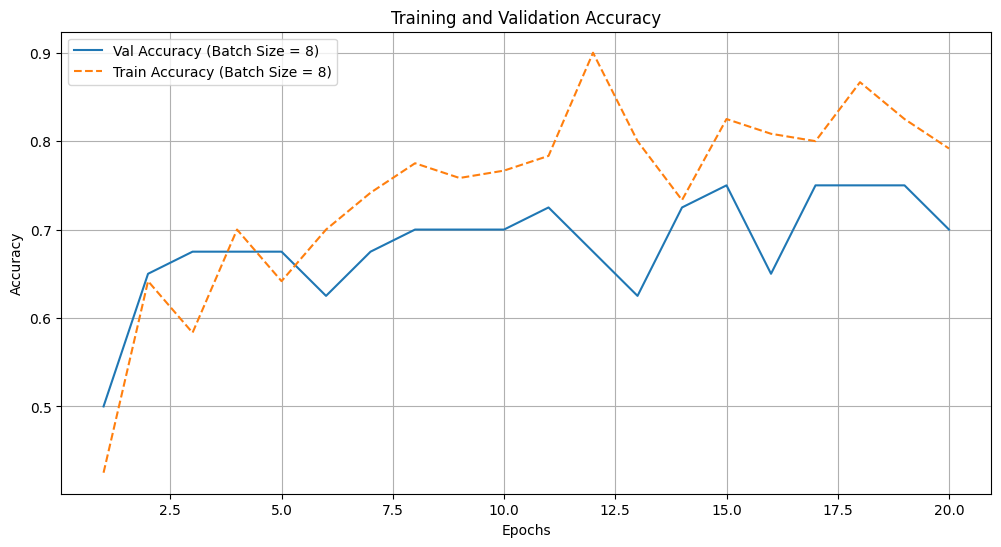

In [123]:
plt.figure(figsize=(12, 6))

val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy, label=f'Val Accuracy (Batch Size = 8)')
plt.plot(epochs, train_accuracy, linestyle='--', label=f'Train Accuracy (Batch Size = 8)')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [130]:
batch_sizes = [16, 32]  
history_list = {}  # 각 배치 사이즈에 대한 학습 히스토리를 저장할 딕셔너리
history_list[8] = history

In [132]:
# 각 배치 사이즈에 대해 모델 학습
for batch_size in batch_sizes:
    print(f"Training model with batch size: {batch_size}")
    
    # 모델 생성 및 컴파일
    model_vgg = create_compile_model_vgg16()

    # 학습
    history = model_vgg.fit(
        train_data, 
        train_labels, 
        batch_size=batch_size, 
        epochs=50, 
        validation_data=(val_data, val_labels), 
        callbacks=[reduce_lr, early_stopping]
    )

    # 학습 히스토리를 저장
    history_list[batch_size] = history

Training model with batch size: 16
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4751 - loss: 35.4387 - val_accuracy: 0.5000 - val_loss: 9.0625 - learning_rate: 0.0100
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4779 - loss: 9.5317 - val_accuracy: 0.6750 - val_loss: 0.7378 - learning_rate: 0.0100
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6074 - loss: 2.5089 - val_accuracy: 0.7250 - val_loss: 0.5786 - learning_rate: 0.0100
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6175 - loss: 0.8014 - val_accuracy: 0.6000 - val_loss: 0.6368 - learning_rate: 0.0100
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4971 - loss: 0.8197 - val_accuracy: 0.6250 - val_loss: 0.6463 - learning_rate: 0.0100
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7699 - loss: 0.6217 - val_accuracy: 0.6500 - val_loss: 0.6464 - learning_rate: 0.0100
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6951 - loss: 0

In [140]:
# 각 배치 사이즈의 validation accuracy 출력
for batch_size, history in history_list.items():
    val_accuracy = history.history['val_accuracy']
    accuracy = history.history['accuracy']
    print(f"Batch Size: {batch_size} - Accuracy: {accuracy[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.4f}")

Batch Size: 8 - Accuracy: 0.7917, Validation Accuracy: 0.7000
Batch Size: 16 - Accuracy: 0.6750, Validation Accuracy: 0.7500
Batch Size: 32 - Accuracy: 0.8250, Validation Accuracy: 0.6750


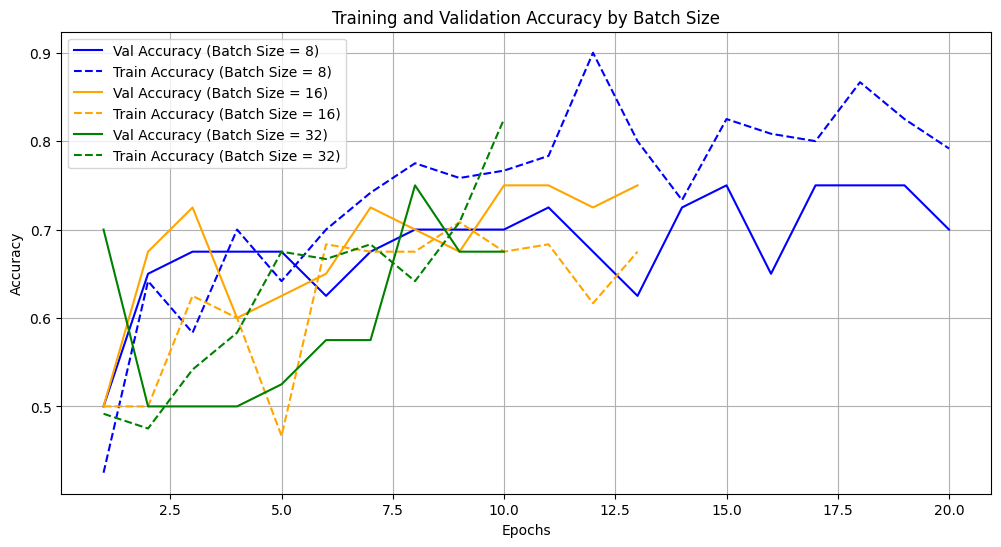

In [141]:
plt.figure(figsize=(12, 6))

# 배치 사이즈별 색상 설정
colors = {
    8: 'blue',
    16: 'orange',
    32: 'green',
}


for batch_size, history in history_list.items():
    val_accuracy = history.history['val_accuracy']
    train_accuracy = history.history['accuracy']
    epochs = range(1, len(val_accuracy) + 1)
    
    plt.plot(epochs, val_accuracy, color=colors[batch_size], label=f'Val Accuracy (Batch Size = {batch_size})')
    plt.plot(epochs, train_accuracy, linestyle='--', color=colors[batch_size], label=f'Train Accuracy (Batch Size = {batch_size})')

plt.title('Training and Validation Accuracy by Batch Size')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### 2) EfficientNetB0 사용

In [190]:
# EfficientNetB0 모델 생성
def create_compile_model_ENB():
    enb = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
    enb.trainable = False

    # 상위 층 고정 및 하위 층 학습 가능 설정
    for layer in enb.layers[:150]:  # 첫 150개 층 고정
        layer.trainable = False
    for layer in enb.layers[150:]:  # 나머지 층 학습 가능
        layer.trainable = True

    model = models.Sequential()
    model.add(enb) # EfficientNetB0 추가
    model.add(layers.GlobalAveragePooling2D()) # flatten 대체
    model.add(layers.Dense(256, activation='relu', name='dense_256'))
    model.add(layers.Dropout(0.5, name='dropout'))
    model.add(layers.Dense(1, activation='sigmoid', name='predictions')) # 이진 분류를 위해 sigmoid 사용
    
    model.compile(loss='binary_crossentropy',  # 이진 분류
                    optimizer=Adam(learning_rate=0.0001), 
                    metrics=['accuracy'])
    
    return model

In [191]:
# 모델 생성 및 컴파일
model_enb = create_compile_model_ENB()

# 학습
history = model_enb.fit(train_data, 
                    train_labels, 
                    batch_size=16,
                    epochs=50, 
                    validation_data=(val_data, val_labels), 
                    callbacks=[reduce_lr, early_stopping]
        )

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 406ms/step - accuracy: 0.4818 - loss: 0.7491 - val_accuracy: 0.5000 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.4229 - loss: 0.7719 - val_accuracy: 0.5000 - val_loss: 0.6939 - learning_rate: 1.0000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.5843 - loss: 0.6796 - val_accuracy: 0.5000 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.5144 - loss: 0.7326 - val_accuracy: 0.5000 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.4691 - loss: 0.7771 - val_accuracy: 0.4750 - val_loss: 0.6933 - learning_rate: 1.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.4905 - loss: 0.6821 - val_accuracy: 0.5000 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.4244 - loss

### 3) 기존 CNN 모델

In [204]:
train_data = sagittal["train"]
val_data = sagittal["val"]

print("train_data shape:", train_data.shape)  
print("val_data shape:", val_data.shape)

train_data shape: (120, 224, 224, 1)
val_data shape: (40, 224, 224, 1)


In [210]:
# 모델 생성 및 컴파일 함수
def create_compile_model_CNN():
    model = models.Sequential()
    
  # 첫 번째 합성곱층
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.))
    
    # 두 번째 합성곱층
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # 세 번째 합성곱층
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # 평탄화
    model.add(layers.Flatten())
    
    # 완전 연결층
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # 이진 분류를 위한 출력층

    # 컴파일
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [211]:
# 모델 생성 및 컴파일
model_cnn = create_compile_model_CNN()

# 학습
history = model_cnn.fit(train_data, 
                    train_labels, 
                    batch_size=32,
                    epochs=50, 
                    validation_data=(val_data, val_labels), 
                    callbacks=[reduce_lr, early_stopping] 
        )

Epoch 1/50


/Users/chaewon/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 805ms/step - accuracy: 0.5002 - loss: 32.3306 - val_accuracy: 0.5500 - val_loss: 4.8522 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step - accuracy: 0.6473 - loss: 13.9268 - val_accuracy: 0.5000 - val_loss: 5.6871 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step - accuracy: 0.5042 - loss: 11.4489 - val_accuracy: 0.5000 - val_loss: 7.1633 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step - accuracy: 0.5694 - loss: 7.5093 - val_accuracy: 0.5000 - val_loss: 9.2960 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step - accuracy: 0.6229 - loss: 6.0327 - val_accuracy: 0.5000 - val_loss: 11.6350 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step - accuracy: 0.6150 - loss: 5.8263 - val_accuracy: 0.5000 - val_loss: 13.7351 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step - accuracy: 0.6475 - loss: 5.6231 - val_accuracy: 0.5000